In [1]:
import os, sys

import mdtraj as md
import numpy as np
import datetime
import tensorflow as tf
import nglview as nv
import matplotlib.pyplot as plt

%cd /home/jovyan/ASMSA/mydev


repo_dir = os.getcwd()   
if repo_dir not in sys.path:
    sys.path.insert(0, repo_dir)

from src.utils import plot_latent_space
from src.asmsa_callbacks import callbacks
from src.vae import asmsa_beta_vae
from src.asmsa_features import process_trajectory
from src.asmsa_split import  split_dataset
from src.asmsa_loss import asmsa_ae_loss
from src.asmsa_analysis import analyze_reconstruction_with_sincos_blocks, plot_section_errors

nn_model = 'vae'
latent_dim = 2

2025-08-28 16:10:06.212901: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-28 16:10:06.227014: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-28 16:10:06.231152: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-28 16:10:06.241049: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-28 16:10:06.965663: W tensorflow/compiler/tf2

[Errno 2] No such file or directory: '/home/jovyan/ASMSA/mydev'
/home/tedeschg/prj/ASMSA/mydev


In [2]:
tr = "trpcage_ds_nH.xtc"
conf = "trpcage_npt400_nH.pdb"

traj = md.load_xtc(tr, top=conf)
backbone_atoms = traj.topology.select('backbone')
traj.superpose(traj, 0, atom_indices=backbone_atoms)

<mdtraj.Trajectory with 50001 frames, 144 atoms, 20 residues, and unitcells at 0x723f42d72d40>

In [3]:
view = nv.show_mdtraj(traj)

view.add_representation('line', selection='protein')
view

NGLWidget(max_frame=50000)

In [4]:
feat = process_trajectory(tr, conf)

## NN preprocessing

In [5]:
# Uso:
ds_train, ds_val, ds_test, ds_all, info = split_dataset(feat['features_normalized'], train_size=70, val_size=15, batch_size=64, seed=42)

I0000 00:00:1756390211.887575   82748 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1756390211.906405   82748 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1756390211.906564   82748 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1756390211.907311   82748 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Dataset Split Statistics:
  Total samples: 50001
  Train: 35000 samples (70.0%), 546 batches
  Val:   7500 samples (15.0%), 118 batches
  Test:  7501 samples (15.0%), 118 batches
  Batch size: 64
  Features shape: (50001, 116)
  Seed: 42


# VAE

In [6]:
nD = feat['n_distance_features']
nA = feat['n_angle_features']

In [7]:
log_dir = "logs/autoencoder/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

cb = callbacks(log_dir, latent_dim, monitor="val_reconstruction_loss", model=nn_model)



In [8]:
beta_vae, enc, dec = asmsa_beta_vae(
    n_features=feat['features_normalized'].shape[1],
    latent_dim=latent_dim,
    activation="gelu",
    recon_loss_weight=1.0,
    beta=0.001,
    cov_reg=1e-3,
    recon_fn=asmsa_ae_loss(nD, nA, deltaD=0.1, deltaA=0.5, wD=None, wA=None)       
)


In [9]:
beta_vae.fit(ds_train, epochs=500, validation_data=ds_val, callbacks=cb)

Epoch 000 → beta=0.001000
Epoch 1/500


I0000 00:00:1756390216.380637   82799 service.cc:146] XLA service 0x5fad57ec1b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756390216.380656   82799 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-08-28 16:10:16.459937: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-28 16:10:16.911957: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 36/546 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - cov_reg_weight: 0.0010 - kl_loss: 4.1962e-04 - kl_loss_unweighted: 0.4196 - loss: 0.1448 - reconstruction_loss: 0.1439 - whiten_reg: 4.9215e-04

I0000 00:00:1756390221.269526   82799 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


543/546 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cov_reg_weight: 1.0000e-03 - kl_loss: 0.0016 - kl_loss_unweighted: 1.6281 - loss: 0.1184 - reconstruction_loss: 0.1144 - whiten_reg: 0.0025
Epoch 1: val_reconstruction_loss improved from inf to 0.07775, saving model to vae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - cov_reg_weight: 1.0000e-03 - kl_loss: 0.0016 - kl_loss_unweighted: 1.6301 - loss: 0.1183 - reconstruction_loss: 0.1142 - whiten_reg: 0.0025 - val_cov_reg_weight: 0.0010 - val_kl_loss: 0.0016 - val_kl_loss_unweighted: 1.6145 - val_loss: 0.0809 - val_reconstruction_loss: 0.0777 - val_whiten_reg: 0.0016 - learning_rate: 1.0000e-04
Epoch 001 → beta=0.040980
Epoch 2/500
 35/546 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - cov_reg_weight: 0.0010 - kl_loss: 0.0016 - kl_loss_unweighted: 1.6372 - loss: 0.0823 - reconstruction_loss: 0.0791 - whiten_reg: 0.0015

/home/tedeschg/miniforge3/envs/asmsa/lib/python3.10/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cov_reg_weight: 1.0000e-03 - kl_loss: 0.0016 - kl_loss_unweighted: 1.6356 - loss: 0.0815 - reconstruction_loss: 0.0785 - whiten_reg: 0.0013
Epoch 2: val_reconstruction_loss improved from 0.07775 to 0.07394, saving model to vae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - cov_reg_weight: 1.0000e-03 - kl_loss: 0.0016 - kl_loss_unweighted: 1.6357 - loss: 0.0815 - reconstruction_loss: 0.0785 - whiten_reg: 0.0013 - val_cov_reg_weight: 0.0010 - val_kl_loss: 0.0016 - val_kl_loss_unweighted: 1.6438 - val_loss: 0.0765 - val_reconstruction_loss: 0.0739 - val_whiten_reg: 9.1607e-04 - learning_rate: 1.0000e-04
Epoch 002 → beta=0.080960
Epoch 3/500
542/546 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cov_reg_weight: 1.0000e-03 - kl_loss: 0.0016 - kl_loss_unweighted: 1.6437 - loss: 0.0774 - reconstruction_loss: 0.0750 - whiten_reg: 7.8850e-04
Epoch 3: val_reconstruction_loss improved from 0.07394 to 0.07252, saving model to vae_2d.keras
546/546 ━━━━━━━━━━━━━━━

In [10]:
src = f"vae_{latent_dim}d.keras"
dest = "/home/tedeschg/prj/ASMSA/mydev/models/"

!mv {src} {dest}

In [11]:
print("cov_reg =", float(beta_vae.cov_reg.numpy()))


cov_reg = 0.0010000000474974513


tensorboard --logdir logs/autoencoder --host localhost --port 6006

# Decode and visualize

In [12]:
enc.save('./models/encoder_vae.keras')
dec.save('./models/decoder_vae.keras')


In [13]:
for batch_x, _ in ds_test.take(1):
    sample_x = batch_x[30]  
    break
    
sample_x_batch = tf.expand_dims(sample_x, axis=0)
z_mean, z_log_var, test = enc.predict(sample_x_batch)

z_mean

2025-08-28 16:15:34.329307: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


array([[ 2.2678902 , -0.42056328]], dtype=float32)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


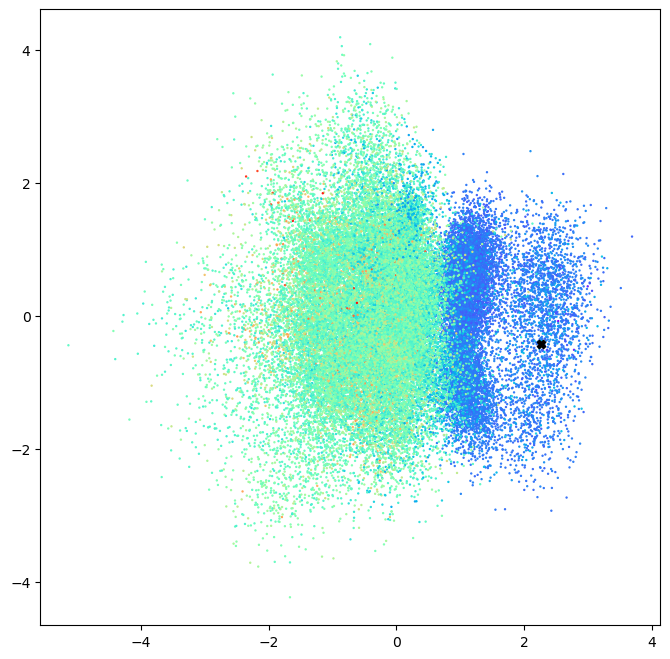

In [14]:
target = np.array([0,-2]).reshape(1, latent_dim)
bb_indices = traj.topology.select('backbone')
ca_indices = traj.topology.select('name CA')
emb, sample = plot_latent_space(latent_dim, enc, ds_all, conf, tr, z_mean, bb_indices, model=nn_model, exact=False)

In [15]:
rms_ref = md.load_pdb(conf)
rms_ref_bb  = rms_ref.atom_slice(bb_indices)
rms_ref_ca  = rms_ref.atom_slice(ca_indices)
rms_tr = md.load_xtc(tr, top=rms_ref)
rmsd = md.rmsd(rms_tr, rms_ref)

In [16]:
p_indices = traj.topology.select("protein")
n_p = len(p_indices)

In [17]:
'''
s = dec.predict(sample)

coords_size = feat['coords'].shape[1]  # dimensione delle coordinate
angles_size = s.shape[1] - coords_size  # dimensione degli angoli

# Separa coordinate e angoli
s_coords = s[:, :coords_size]
s_angles = s[:, coords_size:]

# Inverti le trasformazioni separatamente
coords_orig = feat['scaler_coords'].inverse_transform(s_coords)
angles_orig = feat['scaler_angles'].inverse_transform(s_angles)

# Prendi solo le coordinate per la ricostruzione
coords_flat = coords_orig[0, :]                    
coords_p = coords_flat.reshape((n_p, 3))
mask_bb = np.isin(p_indices, bb_indices)
coords_bb = coords_p[mask_bb] 
coords_ca = coords_bb[1::4] 

new_traj = md.Trajectory(
    xyz=np.array([coords_bb]),     
    topology=rms_ref_bb.topology     
)
new_traj.save_pdb("./models/vae_reconstructed.pdb")
'''

'\ns = dec.predict(sample)\n\ncoords_size = feat[\'coords\'].shape[1]  # dimensione delle coordinate\nangles_size = s.shape[1] - coords_size  # dimensione degli angoli\n\n# Separa coordinate e angoli\ns_coords = s[:, :coords_size]\ns_angles = s[:, coords_size:]\n\n# Inverti le trasformazioni separatamente\ncoords_orig = feat[\'scaler_coords\'].inverse_transform(s_coords)\nangles_orig = feat[\'scaler_angles\'].inverse_transform(s_angles)\n\n# Prendi solo le coordinate per la ricostruzione\ncoords_flat = coords_orig[0, :]                    \ncoords_p = coords_flat.reshape((n_p, 3))\nmask_bb = np.isin(p_indices, bb_indices)\ncoords_bb = coords_p[mask_bb] \ncoords_ca = coords_bb[1::4] \n\nnew_traj = md.Trajectory(\n    xyz=np.array([coords_bb]),     \n    topology=rms_ref_bb.topology     \n)\nnew_traj.save_pdb("./models/vae_reconstructed.pdb")\n'

In [18]:
'''
view = nv.show_file('./models/vae_reconstructed.pdb')
view.clear_representations()
view.add_line() 
#view.add_cartoon()
view.center()
view
'''

"\nview = nv.show_file('./models/vae_reconstructed.pdb')\nview.clear_representations()\nview.add_line() \n#view.add_cartoon()\nview.center()\nview\n"

In [19]:
print(f'distances feat: {nD}, angles feat: {nA}')

distances feat: 40, angles feat: 76


In [20]:
s = dec.predict(sample)
orig = sample_x.numpy() 
recon = s[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


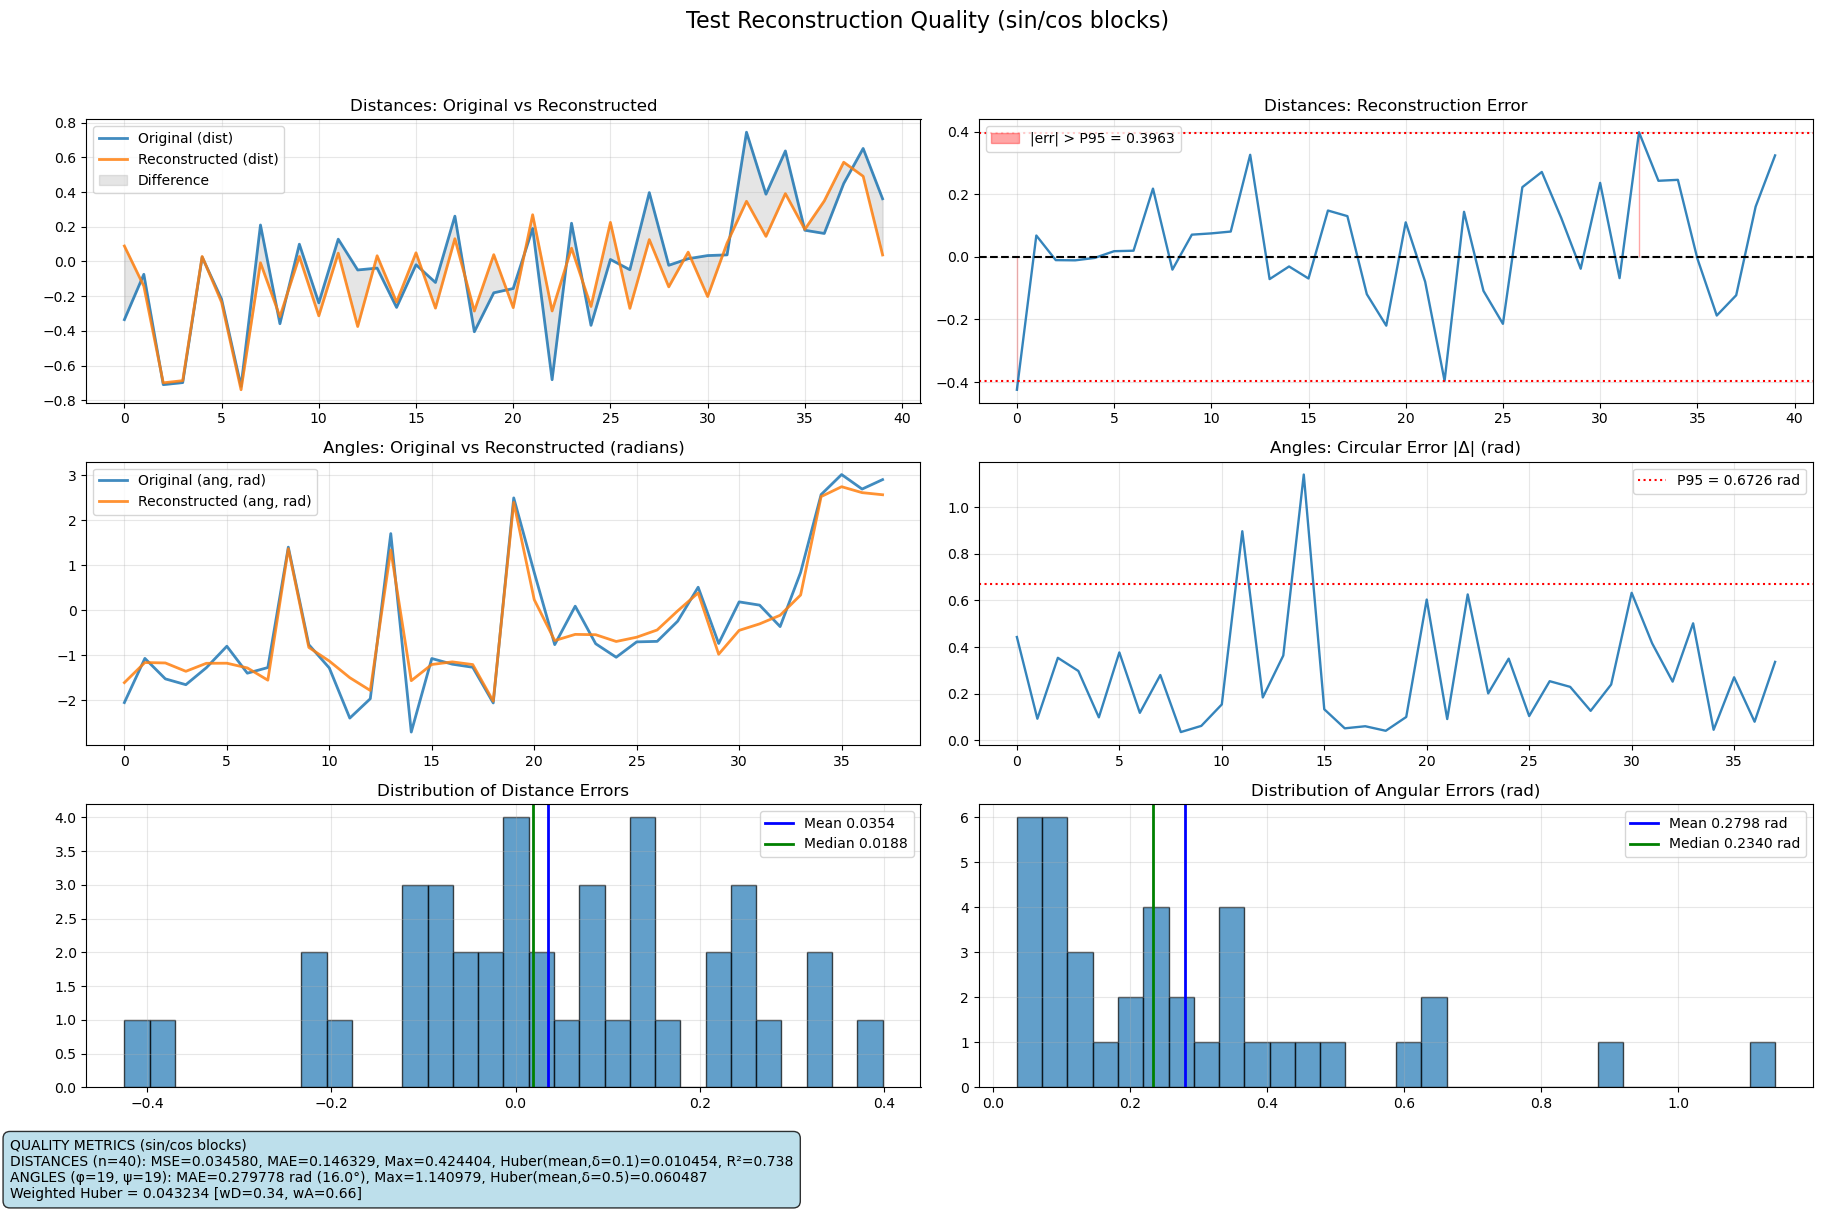

{'distances': {'mse': 0.03457958251237869, 'mae': 0.1463293731212616, 'max_abs_error': 0.42440372705459595, 'huber_mean': 0.010454036295413971, 'r_squared': 0.7376843802476344, 'correlation': 0.8588855454876595}, 'angles': {'circ_mae_rad': 0.2797778248786926, 'circ_mae_deg': 16.03008856689933, 'max_circ_error_rad': 1.1409794092178345, 'huber_mean_circ': 0.0604865662753582}, 'weights': {'distances': 0.3448275862068966, 'angles': 0.6551724137931034}, 'overall_weighted_huber': 0.04323396973054985}


In [21]:
n_phi = 0 if feat['raw_angles']['phi'] is None else feat['raw_angles']['phi'].shape[1]
n_psi = 0 if feat['raw_angles']['psi'] is None else feat['raw_angles']['psi'].shape[1]

fig, metrics = analyze_reconstruction_with_sincos_blocks(
    orig, recon,
    nD=nD, n_phi=n_phi, n_psi=n_psi,
    deltaD=0.1, deltaA=0.5,
    title_prefix="Test "
)

plt.show()
print(metrics)

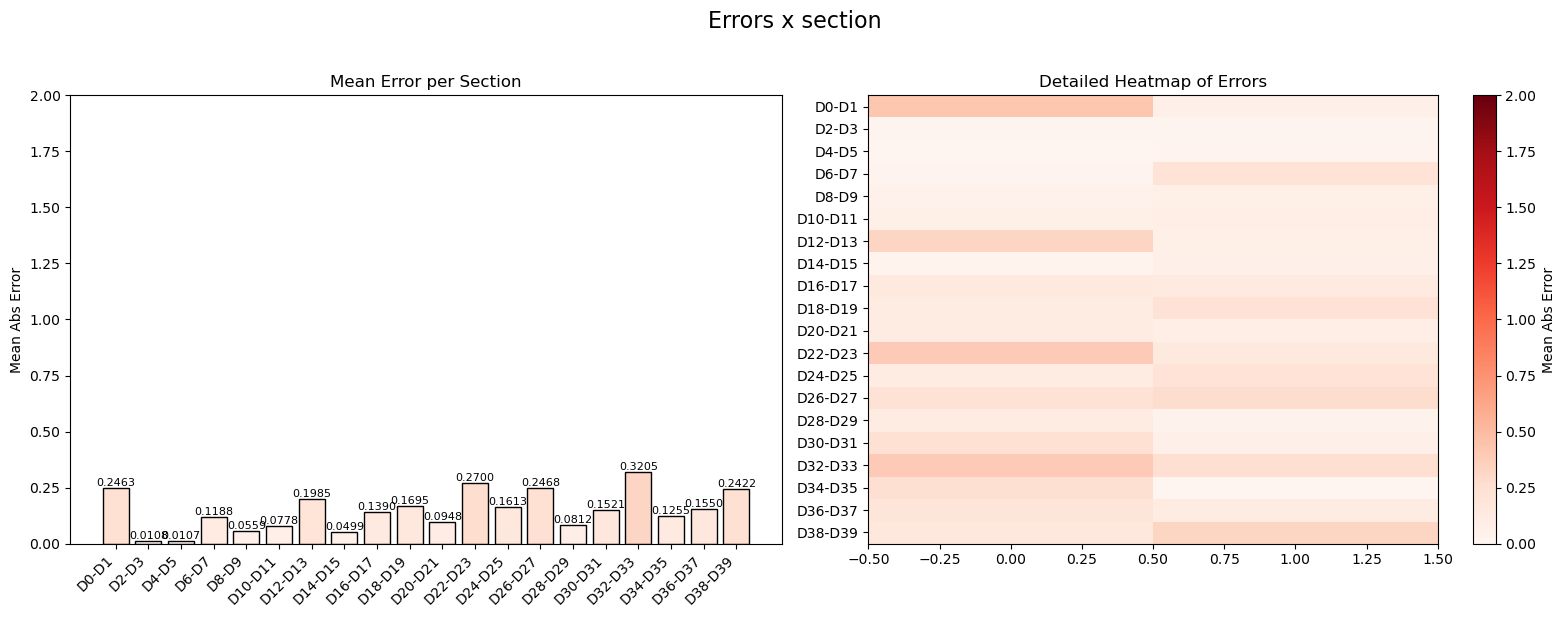

{'sections': [0.2462639957666397, 0.010820060968399048, 0.01074162870645523, 0.11876998841762543, 0.05586351081728935, 0.07784198224544525, 0.19846954941749573, 0.04992450401186943, 0.13898000121116638, 0.16952848434448242, 0.09480097889900208, 0.27003738284111023, 0.1612948179244995, 0.24682903289794922, 0.08115916699171066, 0.1520862579345703, 0.32047584652900696, 0.12547160685062408, 0.15503466129302979, 0.2421942502260208], 'labels': ['D0-D1', 'D2-D3', 'D4-D5', 'D6-D7', 'D8-D9', 'D10-D11', 'D12-D13', 'D14-D15', 'D16-D17', 'D18-D19', 'D20-D21', 'D22-D23', 'D24-D25', 'D26-D27', 'D28-D29', 'D30-D31', 'D32-D33', 'D34-D35', 'D36-D37', 'D38-D39'], 'kind': 'distance'}


In [22]:
fig, sec_stats = plot_section_errors(
    orig, recon,
    nD=nD, n_phi=n_phi, n_psi=n_psi,
    n_sections=20,     
    kind="distance",  
    title="Errors x section"
)

plt.show()
print(sec_stats)

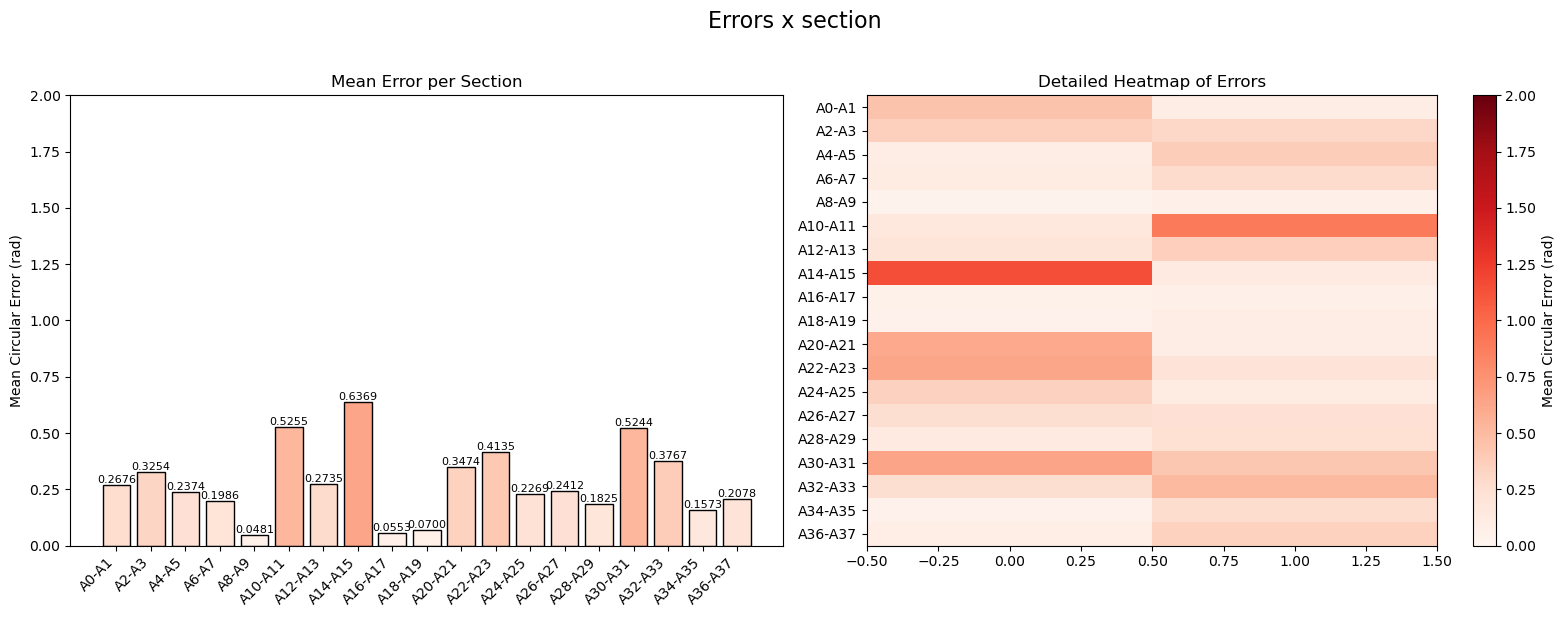

{'sections': [0.267569899559021, 0.32544320821762085, 0.2374143898487091, 0.19861042499542236, 0.04807189106941223, 0.52547687292099, 0.2734503149986267, 0.6368602514266968, 0.055338144302368164, 0.0699700117111206, 0.347357839345932, 0.41346475481987, 0.22687563300132751, 0.24116075038909912, 0.18249650299549103, 0.5244449377059937, 0.37668824195861816, 0.15732252597808838, 0.20776236057281494], 'labels': ['A0-A1', 'A2-A3', 'A4-A5', 'A6-A7', 'A8-A9', 'A10-A11', 'A12-A13', 'A14-A15', 'A16-A17', 'A18-A19', 'A20-A21', 'A22-A23', 'A24-A25', 'A26-A27', 'A28-A29', 'A30-A31', 'A32-A33', 'A34-A35', 'A36-A37'], 'kind': 'angle'}


In [23]:
fig, sec_stats = plot_section_errors(
    orig, recon,
    nD=nD, n_phi=n_phi, n_psi=n_psi,
    n_sections=19,     
    kind="angle",  
    title="Errors x section"
)

plt.show()
print(sec_stats)

In [24]:
def collect_latents(encoder, dataset, has_logvar=True, latent_selector=None, debug_every=0):
    """
    encoder: Keras model
    dataset: tf.data.Dataset -> (x, [factors?])
    has_logvar: se True, ci aspettiamo (mu, logvar)
    latent_selector: callable opzionale (out) -> mu_vector (B, Z) e (optional) logvar (B, Z)
                     Esempio:
                        def latent_selector(out):
                            mu, logvar = out  # o out["mu"], out["logvar"]
                            return mu, logvar
                     Se ritorna solo mu, metti return mu, None
    debug_every: se >0, stampa forma latente ogni N batch
    """
    def _select_mu_logvar(out):
        # Se l'utente fornisce un selector, usalo
        if latent_selector is not None:
            sel = latent_selector(out)
            if isinstance(sel, (list, tuple)):
                if len(sel) == 2:
                    return tf.convert_to_tensor(sel[0]), (None if sel[1] is None else tf.convert_to_tensor(sel[1]))
                else:
                    return tf.convert_to_tensor(sel[0]), None
            else:
                return tf.convert_to_tensor(sel), None

        # Altrimenti prova ad inferire
        if has_logvar and isinstance(out, (list, tuple)) and len(out) >= 2:
            mu, logvar = out[0], out[1]
        elif isinstance(out, dict):
            if "mu" in out:
                mu = out["mu"]
                logvar = out.get("logvar", None)
            elif "z" in out:
                mu = out["z"]
                logvar = out.get("logvar", None)
            else:
                # prendi il primo valore
                key0 = list(out.keys())[0]
                mu = out[key0]
                logvar = None
        else:
            mu, logvar = out, None

        mu = tf.convert_to_tensor(mu)

        # Se arriva una feature map (B,H,W,C) -> GlobalAveragePooling su H,W
        if mu.shape.rank is not None and mu.shape.rank > 2:
            # GAP su tutti gli assi eccetto batch
            reduce_axes = list(range(1, mu.shape.rank-1))  # tipicamente [1,2]
            if len(reduce_axes) > 0:
                mu = tf.reduce_mean(mu, axis=reduce_axes)  # (B, C) se NHWC

        # Se ancora non è 2D, appiattisci
        if mu.shape.rank is not None and mu.shape.rank != 2:
            mu = tf.reshape(mu, [tf.shape(mu)[0], -1])  # (B, Z)

        logvar_t = None
        if logvar is not None:
            logvar_t = tf.convert_to_tensor(logvar)
            if logvar_t.shape.rank is not None and logvar_t.shape.rank > 2:
                reduce_axes = list(range(1, logvar_t.shape.rank-1))
                if len(reduce_axes) > 0:
                    logvar_t = tf.reduce_mean(logvar_t, axis=reduce_axes)
            if logvar_t.shape.rank is not None and logvar_t.shape.rank != 2:
                logvar_t = tf.reshape(logvar_t, [tf.shape(logvar_t)[0], -1])

            # assicurati che mu e logvar abbiano la stessa Z
            if (mu.shape.rank == 2 and logvar_t.shape.rank == 2 and
                (mu.shape[-1] != logvar_t.shape[-1])):
                # allineamento forzato: taglia alla minima Z
                z = min(int(mu.shape[-1]), int(logvar_t.shape[-1]))
                mu = mu[:, :z]
                logvar_t = logvar_t[:, :z]

        return mu, logvar_t

    mus, logvars, factors = [], [], []
    latent_dim = None
    batch_idx = 0

    for batch in dataset:
        if isinstance(batch, (tuple, list)):
            x = batch[0]
            rest = batch[1:]
        else:
            x, rest = batch, []

        out = encoder(x, training=False)
        mu_t, logvar_t = _select_mu_logvar(out)

        # Controllo consistenza Z
        z_now = int(mu_t.shape[-1])
        if latent_dim is None:
            latent_dim = z_now
        elif z_now != latent_dim:
            raise ValueError(
                f"Inconsistenza dimensione latente al batch {batch_idx}: "
                f"atteso Z={latent_dim}, ottenuto Z={z_now}. "
                f"Probabile uscita diversa dell'encoder tra i batch. "
                f"Suggerimento: specifica un 'latent_selector' che ritorni sempre lo stesso vettore (B, Z)."
            )

        mus.append(mu_t.numpy())
        if logvar_t is not None:
            logvars.append(logvar_t.numpy())

        if len(rest) >= 1:
            f = tf.convert_to_tensor(rest[0]).numpy()
            factors.append(f)

        if debug_every and (batch_idx % debug_every == 0):
            print(f"[collect_latents] batch {batch_idx} -> mu shape: {mu_t.shape}")

        batch_idx += 1

    mus = np.concatenate(mus, axis=0)
    logvars = np.concatenate(logvars, axis=0) if len(logvars) > 0 else None
    factors = np.concatenate(factors, axis=0) if len(factors) > 0 else None

    kl_per_dim = None
    if logvars is not None:
        kl = 0.5 * (np.square(mus) + np.exp(logvars) - logvars - 1.0)
        kl_per_dim = kl.mean(axis=0)

    return mus, kl_per_dim, factors


In [25]:
class EncWrap(tf.keras.Model):
    def __init__(self, base):
        super().__init__()
        self.base = base
    def call(self, x, training=False):
        out = self.base(x, training=training)
        # seleziona e formatta qui dentro:
        if isinstance(out, (list, tuple)):
            z = out[0]  # adatta in base al tuo modello
        elif isinstance(out, dict):
            z = out['z']  # o 'mu'
        else:
            z = out
        # Se esce feature map, fai GAP:
        if len(z.shape) > 2:
            z = tf.reduce_mean(z, axis=list(range(1, len(z.shape)-1)))
        return z  # (B, Z)

enc_fixed = EncWrap(enc)
results = evaluate_disentanglement(
    encoder=enc_fixed,
    dataset=ds_val,
    has_logvar=False,
    have_factors=False,
)


NameError: name 'evaluate_disentanglement' is not defined